#  CIFAR10 Image Classification with PyTorch

## About

The goal of the homework is to train a convolutional neural network on the standard CIFAR10 image classfication dataset.

When solving machine learning tasks using neural networks, one typically starts with a simple network architecture and then improves the network by adding new layers, retraining, adjusting parameters, retraining, etc.  We attempt to illustrate this process below with several architecture improvements.


In [1]:
import torch
torch.rand(5, 3)

tensor([[0.8038, 0.8680, 0.1140],
        [0.2192, 0.4750, 0.1847],
        [0.1457, 0.1643, 0.4454],
        [0.6511, 0.0645, 0.6108],
        [0.3816, 0.5458, 0.8831]])

## Part 0 Imports and Basic Setup

In [0]:
import numpy as np
import torch
from torch import nn
from torch import optim

import matplotlib.pyplot as plt

In [3]:
import torch.cuda as cuda

# Use a GPU, i.e. cuda:0 device if it available.
device = torch.device("cuda:0" if cuda.is_available() else "cpu")
print(device)

cuda:0


### Training Code

In [0]:
import time

class Flatten(nn.Module):
  """NN Module that flattens the incoming tensor."""
  def forward(self, input):
    return input.view(input.size(0), -1)
  
def train(model, train_loader, test_loader, loss_func, opt, num_epochs=10):
  all_training_loss = np.zeros((0,2))
  all_training_acc = np.zeros((0,2))
  all_test_loss = np.zeros((0,2))
  all_test_acc = np.zeros((0,2))
  
  training_step = 0
  training_loss, training_acc = 2.0, 0.0
  print_every = 1000
  
  start = time.clock()
  
  for i in range(num_epochs):
    epoch_start = time.clock() 
   
    model.train()
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      opt.zero_grad()

      preds = model(images)
      loss = loss_func(preds, labels)
      loss.backward()
      opt.step()
      
      training_loss += loss.item()
      training_acc += (torch.argmax(preds, dim=1)==labels).float().mean()
      
      if training_step % print_every == 0:
        training_loss /= print_every
        training_acc /= print_every
        
        all_training_loss = np.concatenate((all_training_loss, [[training_step, training_loss]]))
        all_training_acc = np.concatenate((all_training_acc, [[training_step, training_acc]]))
        
        print('  Epoch %d @ step %d: Train Loss: %3f, Train Accuracy: %3f' % (
            i, training_step, training_loss, training_acc))
        training_loss, training_acc = 0.0, 0.0
        
      training_step+=1

    model.eval()
    with torch.no_grad():
      validation_loss, validation_acc = 0.0, 0.0
      count = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        validation_loss+=loss_func(output,labels)
        validation_acc+=(torch.argmax(output, dim=1) == labels).float().mean()
        count += 1
      validation_loss/=count
      validation_acc/=count
      
      all_test_loss = np.concatenate((all_test_loss, [[training_step, validation_loss]]))
      all_test_acc = np.concatenate((all_test_acc, [[training_step, validation_acc]]))
      
      epoch_time = time.clock() - epoch_start
      
      print('Epoch %d Test Loss: %3f, Test Accuracy: %3f, time: %.1fs' % (
          i, validation_loss, validation_acc, epoch_time))
      
  total_time = time.clock() - start
  print('Final Test Loss: %3f, Test Accuracy: %3f, Total time: %.1fs' % (
      validation_loss, validation_acc, total_time))

  return {'loss': { 'train': all_training_loss, 'test': all_test_loss },
          'accuracy': { 'train': all_training_acc, 'test': all_test_acc }}

def plot_graphs(model_name, metrics):
  for metric, values in metrics.items():
    for name, v in values.items():
      plt.plot(v[:,0], v[:,1], label=name)
    plt.title(f'{metric} for {model_name}')
    plt.legend()
    plt.xlabel("Training Steps")
    plt.ylabel(metric)
    plt.show()
    

Load the** CIFA-10** dataset and define the transformations. You may also want to print its structure, size, as well as sample a few images to get a sense of how to design the network. 

In [5]:
!mkdir hw10_data

mkdir: cannot create directory ‘hw10_data’: File exists


In [6]:
# Download the data.
from torchvision import datasets, transforms

transformations = transforms.Compose([ transforms.RandomRotation(45),
              transforms.ToTensor(),
              transforms.RandomApply([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))], p=0.8)])
                                      
train_set = datasets.CIFAR10(root='hw10_data/', download=True, transform=transformations)
test_set = datasets.CIFAR10(root='hw10_data', download=True, train=False, transform=transformations)

Files already downloaded and verified
Files already downloaded and verified


Use `DataLoader` to create a loader for the training set and a loader for the testing set. You can use a `batch_size` of 8 to start, and change it if you wish.

In [0]:
from torch.utils.data import DataLoader

batch_size = 8
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True, num_workers=2)

input_shape = np.array(train_set[0][0]).shape
input_dim = input_shape[1]*input_shape[2]*input_shape[0]


In [0]:
training_epochs = 5

## Part 1 CIFAR10 with Fully Connected Neural Network

In [9]:
class TwoLayerModel(nn.Module):
  def __init__(self):
    super(TwoLayerModel, self).__init__()
    self.net = nn.Sequential(
      Flatten(), 
      nn.Linear(input_dim, 64), 
      nn.ReLU(), 
      nn.Linear(64, 10))
    
  def forward(self, x):
    return self.net(x)

model = TwoLayerModel().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)

# Training epoch should be about 15-20 sec each on GPU.
metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

  Epoch 0 @ step 0: Train Loss: 0.004388, Train Accuracy: 0.000250
  Epoch 0 @ step 1000: Train Loss: 2.085446, Train Accuracy: 0.254125
  Epoch 0 @ step 2000: Train Loss: 1.949245, Train Accuracy: 0.293250
  Epoch 0 @ step 3000: Train Loss: 1.946982, Train Accuracy: 0.288500
  Epoch 0 @ step 4000: Train Loss: 1.932533, Train Accuracy: 0.293750
  Epoch 0 @ step 5000: Train Loss: 1.937621, Train Accuracy: 0.297000
  Epoch 0 @ step 6000: Train Loss: 1.924164, Train Accuracy: 0.305500
Epoch 0 Test Loss: 1.905797, Test Accuracy: 0.297100, time: 18.8s
  Epoch 1 @ step 7000: Train Loss: 1.925763, Train Accuracy: 0.301625
  Epoch 1 @ step 8000: Train Loss: 1.912601, Train Accuracy: 0.305250
  Epoch 1 @ step 9000: Train Loss: 1.920458, Train Accuracy: 0.306250
  Epoch 1 @ step 10000: Train Loss: 1.912366, Train Accuracy: 0.307125
  Epoch 1 @ step 11000: Train Loss: 1.911517, Train Accuracy: 0.306875
  Epoch 1 @ step 12000: Train Loss: 1.911065, Train Accuracy: 0.308750
Epoch 1 Test Loss: 1.903

**Plot the model results**

Normally we would want to use Tensorboard for looking at metrics.  However, if colab reset while we are working, we might lose our logs and therefore our metrics.  Let's just plot some graphs that will survive across colab instances.

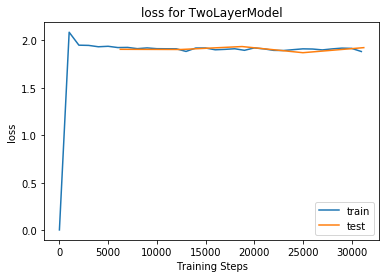

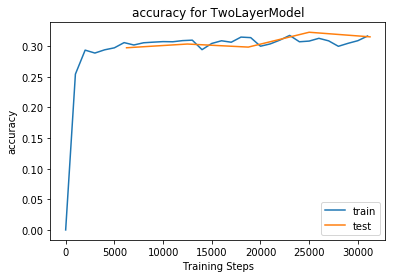

In [10]:
plot_graphs("TwoLayerModel", metrics)

## Part 2 Convolutional Neural Network (CNN) (35 Points)

Now, let's design a convolution neural netwrok!

Build a simple CNN model, inserting 2 CNN layers in from of our 2 layer fully connect model from above:

1. A convolution with	3x3 filter, 16 output channels, stride = 1, padding=1
2. A ReLU activation
2. A Max-Pooling layer with 2x2 window
3. A convolution,	3x3 filter, 16 output channels, stride = 1, padding=1
4. A ReLU activation
4. Flatten layer
5. Fully connected linear layer with output size 64
6. ReLU
7. Fully connected linear layer, with output size 10

You will have to figure out the input sizes of the first fully connnected layer based on the previous layer sizes. Note that you also need to fill those in the report section (see report section in the notebook for details) 

In [11]:
from torchsummary import summary
class ConvModel(nn.Module):
  # Your Code Here
    def __init__(self):
      super(ConvModel, self).__init__()
      self.net = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1), 
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1), 
        nn.ReLU(),
        Flatten(),
        nn.Linear(16*16*4*4, 64),
        nn.ReLU(),
        nn.Linear(64, 10))

    
    def forward(self, x):
      return self.net(x)

model = ConvModel().to(device)
# summary(model, (3, 8, 8))

loss = nn.CrossEntropyLoss()
#optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.001)

metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

  Epoch 0 @ step 0: Train Loss: 0.004279, Train Accuracy: 0.000250
  Epoch 0 @ step 1000: Train Loss: 1.962330, Train Accuracy: 0.274000
  Epoch 0 @ step 2000: Train Loss: 1.662703, Train Accuracy: 0.393125
  Epoch 0 @ step 3000: Train Loss: 1.605250, Train Accuracy: 0.425125
  Epoch 0 @ step 4000: Train Loss: 1.548662, Train Accuracy: 0.438625
  Epoch 0 @ step 5000: Train Loss: 1.518894, Train Accuracy: 0.455625
  Epoch 0 @ step 6000: Train Loss: 1.499595, Train Accuracy: 0.460625
Epoch 0 Test Loss: 1.445889, Test Accuracy: 0.480300, time: 26.4s
  Epoch 1 @ step 7000: Train Loss: 1.467611, Train Accuracy: 0.465000
  Epoch 1 @ step 8000: Train Loss: 1.430365, Train Accuracy: 0.487750
  Epoch 1 @ step 9000: Train Loss: 1.439188, Train Accuracy: 0.477375
  Epoch 1 @ step 10000: Train Loss: 1.430233, Train Accuracy: 0.485625
  Epoch 1 @ step 11000: Train Loss: 1.377378, Train Accuracy: 0.503125
  Epoch 1 @ step 12000: Train Loss: 1.367146, Train Accuracy: 0.512375
Epoch 1 Test Loss: 1.375

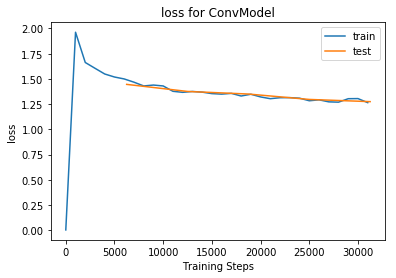

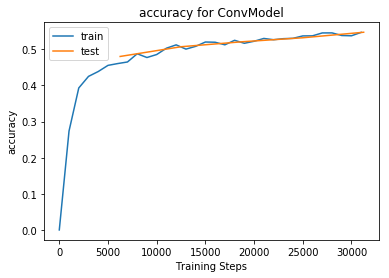

In [12]:
plot_graphs("ConvModel", metrics)

Do you notice the improvement over the accuracy compared to that in Part 1?

## Part 3 Open Design Competition (35 Points + 10 bonus points)

Try to beat the previous models by adding additional layers, changing parameters, etc.  You should add at least one layer.

Possible changes include:
*   Dropout
*   Batch Normalization
*   More layers
*   Residual Connections (harder)
*   Change layer size
*   Pooling layers, stride
*   Different optimizer
*   Train for longer

Once you have a model you think is great, evaluate it against our hidden test data (see hidden_loader above) and upload the results to the leader board on gradescope.  **The top 3 scorers will get a bonus 10 points.**

You can steal model structures found on the internet if you want.  The only constraint is that **you must train the model from scratch**.


In [13]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable

import matplotlib.pyplot as plt

import torch.cuda as cuda

# Use a GPU, i.e. cuda:0 device if it available.
device = torch.device("cuda:0" if cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
!mkdir hw10_data

mkdir: cannot create directory ‘hw10_data’: File exists


In [15]:
# Download the data.
from torchvision import datasets, transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
#      transforms.RandomHorizontalFlip(),
 #   transforms.RandomRotation(45),
    transforms.ToTensor(),
  #  transforms.functional.adjust_saturation(0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),    
    #transforms.functional.adjust_saturation(0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = datasets.CIFAR10(root='hw10_data/', download=True, transform=transform_train)
test_set = datasets.CIFAR10(root='hw10_data', download=True, train=False, transform=transform_test)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False, num_workers=2)


In [0]:
#Convolution Neural Network - Improved Model


class ConvModel2(nn.Module):
    def __init__(self):
         
        super(ConvModel2, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
             nn.MaxPool2d(kernel_size=2, stride=2),
#            nn.Conv2d(64, 64, kernel_size=5, stride=2),
            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
             nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
             nn.MaxPool2d(kernel_size=2, stride=2),
#            nn.Conv2d(256, 256, kernel_size=3, stride=2),

        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
            
        )

    
    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [18]:
#Loss function and Optimizer
model = ConvModel2().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
training_epochs = 25
metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

  Epoch 0 @ step 0: Train Loss: 0.004295, Train Accuracy: 0.000000
  Epoch 0 @ step 1000: Train Loss: 2.090768, Train Accuracy: 0.213625
  Epoch 0 @ step 2000: Train Loss: 1.955404, Train Accuracy: 0.263125
  Epoch 0 @ step 3000: Train Loss: 1.885890, Train Accuracy: 0.271875
  Epoch 0 @ step 4000: Train Loss: 1.829167, Train Accuracy: 0.310750
  Epoch 0 @ step 5000: Train Loss: 1.773145, Train Accuracy: 0.333250
  Epoch 0 @ step 6000: Train Loss: 1.716120, Train Accuracy: 0.355750
Epoch 0 Test Loss: 1.577079, Test Accuracy: 0.408800, time: 54.2s
  Epoch 1 @ step 7000: Train Loss: 1.679845, Train Accuracy: 0.367750
  Epoch 1 @ step 8000: Train Loss: 1.640452, Train Accuracy: 0.383000
  Epoch 1 @ step 9000: Train Loss: 1.573344, Train Accuracy: 0.409125
  Epoch 1 @ step 10000: Train Loss: 1.560879, Train Accuracy: 0.420125
  Epoch 1 @ step 11000: Train Loss: 1.505352, Train Accuracy: 0.437750
  Epoch 1 @ step 12000: Train Loss: 1.468944, Train Accuracy: 0.453250
Epoch 1 Test Loss: 1.311

**What changes did you make to improve your model?**

**We added more convolutional layers so that we could represent more complex relationships in the data and
added dropout to prevent the network from relying too heavily on certain nodes to make its decision.
We also added batch normalization, a well known technique that adjusts the scaling of the activation functions.**

*We tried random scaling and random flips on the train loaders, but these seemed to reduce model quality.*
*We  also tried adding more layers and changing the parameters of the convolution functions, which did not help or reduced model quality.*

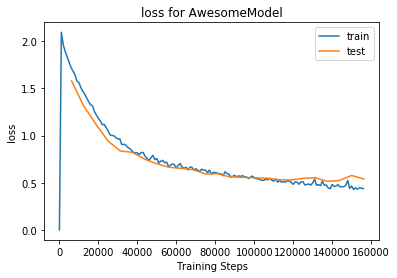

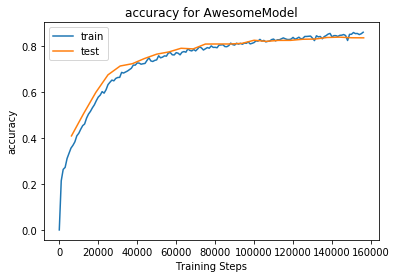

In [19]:
plot_graphs("AwesomeModel", metrics)

After you get a nice model, download the test_file.zip and unzip it to get test_file.pt. In colab, you can explore your files from the left side bar. You can also download the files to your machine from there.

In [20]:
!wget http://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
!unzip test_file.zip

--2019-05-02 04:46:47--  http://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
Resolving courses.engr.illinois.edu (courses.engr.illinois.edu)... 130.126.151.9
Connecting to courses.engr.illinois.edu (courses.engr.illinois.edu)|130.126.151.9|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip [following]
--2019-05-02 04:46:48--  https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
Connecting to courses.engr.illinois.edu (courses.engr.illinois.edu)|130.126.151.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3841776 (3.7M) [application/x-zip-compressed]
Saving to: ‘test_file.zip’

test_file.zip       100%[===================>]   3.66M  12.6MB/s    in 0.3s    

2019-05-02 04:46:48 (12.6 MB/s) - ‘test_file.zip’ saved [3841776/3841776]

Archive:  test_file.zip
  inflating: test_file.pt            


Then use your model to predict the label of the test images. Fill the remaining code below, where x has two dimensions (batch_size x one image size). Remember to reshpe x accordingly before feeding it into your model. The submission.txt should contain one predicted label (0~9) each line. Submit your submission.txt to the competition in gradscope.

In [0]:
import torch.utils.data as Data

test_file = 'test_file.pt'
pred_file = 'submission.txt'

batch_size = 32
device = torch.device("cuda:0" if cuda.is_available() else "cpu")
f_pred = open(pred_file,'w') 
tensor = torch.load(test_file)
torch_dataset = Data.TensorDataset(tensor)  
test_loader = torch.utils.data.DataLoader(torch_dataset, batch_size, shuffle=False, num_workers=2)
model.eval()
with torch.no_grad():
  for ele in test_loader:
      x = ele[0]
      x = x.view(x.size(0), 3, 32, 32)
      x = x.to(device)
      # Fill your code here
      pred = model(x)
      pred = torch.argmax(pred, dim=1)
      for i in range(int(pred.data.size()[0])):
        f_pred.write(str(pred.data[i].item()))
        f_pred.write('\n')
      
    
f_pred.close()


# Report

## Part 0: Imports and Basic Setup
Nothing to report for this part. You will be just scored for finishing the setup.

## Part 1: Fully connected neural networks

Test (on validation set) accuracy (5 Points): 31.49%

Test loss (5 Points): 1.9233

Training time (5 Points): 90.5s


Plots:

- Plot a graph of accuracy on validation set vs training steps (5 Points)

- Plot a graph of loss on validation set vs training steps (5 Points)

#### Plots are in the code section.

## Part 2: Convolution Network (Basic)

Tensor dimensions: A good way to debug your network for size mismatches is to print the dimension of output after every layers:

(10 Points)

Output dimension after 1st conv layer: [-1, 16, 32, 32]

Output dimension after 1st max pooling:  [-1, 16, 16, 16] 

Output dimension after 2nd conv layer:    [-1, 16, 16, 16]

Output dimension after flatten layer: [-1, 4096] 

Output dimension after 1st fully connected layer:  [-1, 64] 

Output dimension after 2nd fully connected layer:   [-1, 10]


Test (on validation set) Accuracy (5 Points): 54.73%

Test loss (5 Points): 1.2749

Training time (5 Points): 134.2s


Plots:

- Plot a graph of accuracy on validation set vs training steps (5 Points)

- Plot a graph of loss on validation set vs training steps (5 Points)

#### Plots are in the code section.

## Part 3: Convolution Network (Add one or more  suggested changes)

Describe the additional changes implemented, your intuition for as to why it works, you may also describe other approaches you experimented with (10 Points):

**We added more convolutional layers so that we could represent more complex relationships in the data and
added dropout to prevent the network from relying too heavily on certain nodes to make its decision.
We also added batch normalization, a well known technique that adjusts the scaling of the activation functions.**

*We tried random scaling and random flips on the train loaders, but these seemed to reduce model quality.*
*We  also tried adding more layers and changing the parameters of the convolution functions, which did not help or reduced model quality.*


Test (on validation set) Accuracy (5 Points): 83.52%

Test loss (5 Points): 0.5424

Training time (5 Points): 1365.0s


Plots:

- Plot a graph of accuracy on validation set vs training steps (5 Points)

- Plot a graph of loss on validation set vs training steps (5 Points)